In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [27]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"

dataset_bank_tns_df = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{smote_suffix}.csv.gz', compression='gzip', index_col='ztf_object_id')
dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [3]:
with open(f'../loci_dbs/alerce_cut/dataset_label_orig_{smote_suffix}.pkl', 'rb') as f:
    dataset_label_orig = pickle.load(f)

In [9]:
dataset_label_orig

['None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN II',
 'SN Ib',
 'SN Ib',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'SN II',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN IIP',
 'SN Ia',
 'None',
 'SN Ib',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'SN Ia',
 'SN II',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'SN II',
 'None',
 'None',
 'None',
 'None',
 'SN Ib',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'N

In [4]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

In [5]:
dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc28309,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535,Fake,TDE,-99.00000,None
ZTFabc68180,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221,Fake,TDE,-99.00000,None
ZTFabc68264,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310,Fake,TDE,-99.00000,None


In [6]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.429100,0.487600,0.394600,0.479000,17.508340,0.363381,Yes_TNS,SN Ia,0.076000,ALeRCE
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,1.987599,2.187201,1.923100,1.677900,127.987642,1.280643,Yes_TNS,SN Ic-BL,0.023563,ZTF
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.537500,0.461899,0.366699,0.308001,73.202796,0.245163,Yes_TNS,SN Ia,0.048167,ZTF
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,1.203501,1.442598,1.337000,1.170200,29.489402,0.282454,Yes_TNS,SN Ia,0.041000,ALeRCE
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.024799,-0.047600,0.003399,-0.067900,37.216605,4.749794,Yes_TNS,SN Ia,0.070000,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.869000,1.001200,1.090099,1.092001,48.668157,0.124452,Yes_TNS,SN Ia-91T-like,0.037437,ALeRCE
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.387199,0.329800,0.383400,0.422300,58.550706,0.012833,Yes_TNS,SN Ia,0.097780,AMPEL
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,1.349999,1.271399,1.157599,1.225500,124.418488,0.916609,Yes_TNS,SN Ia,0.040000,ALeRCE


In [38]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=2500, max_depth=25, random_state=10)
clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

CPU times: user 4min 58s, sys: 1.41 s, total: 5min
Wall time: 5min 2s


RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=10)

In [39]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(dataset_bank_tns_df_resampled_test.iloc[:, 0:120])

In [40]:
clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [41]:
# Predicted Probability to be ['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
#                              'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']
predicted_probability

array([[2.44466333e+01, 4.35027018e-01, 3.24183528e+00, ...,
        1.08048177e-01, 1.76453304e-01, 7.36206299e+00],
       [4.70694205e+00, 0.00000000e+00, 3.98808088e+01, ...,
        1.31386653e+01, 8.00000000e-01, 6.00112233e-01],
       [3.59606398e+01, 2.20032154e+00, 1.81439631e+01, ...,
        5.00000000e-01, 3.00134771e-01, 7.88076305e+00],
       ...,
       [1.40000000e+00, 2.00000000e-01, 5.50018282e+00, ...,
        1.10000000e+00, 1.00000000e-01, 4.00000000e-01],
       [7.01876707e+00, 0.00000000e+00, 2.00959386e+01, ...,
        1.18390996e+01, 4.00000000e-01, 1.12233446e-04],
       [1.08911816e+01, 2.09879911e-01, 4.74228899e+00, ...,
        3.38563793e-01, 1.03154997e+00, 5.22858750e+00]])

In [42]:
clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [43]:
predicted_probability.shape

(455, 12)

In [44]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(dataset_bank_tns_df_resampled_test.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[np.argmax(row.values)], axis=1)
df

,None,SLSN-II,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,
ZTF21aazebgh,24.446633,0.435027,3.241835,0.223705,0.773077,0.806313,59.085444,1.676581,1.664820,0.108048,0.176453,7.362063,SN Ia
ZTF21acgxypn,4.706942,0.000000,39.880809,6.200716,7.149195,1.931035,8.050465,0.353874,17.188187,13.138665,0.800000,0.600112,SN II
ZTF19aapqqrb,35.960640,2.200322,18.143963,0.603846,0.400000,1.479537,23.881055,7.737042,0.912698,0.500000,0.300135,7.880763,None
ZTF21aasbxng,3.683472,0.000000,22.281298,0.300000,2.256852,2.843934,53.110385,5.765987,1.631209,3.322487,3.901745,0.902632,SN Ia
ZTF21aaglgcb,29.603306,5.300000,9.701653,0.000000,0.600000,5.500000,28.294215,12.300826,0.800000,0.000000,0.800000,7.100000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,3.233830,0.100000,12.513797,0.000000,8.478126,3.473228,58.761144,6.374638,0.701579,2.304181,1.709477,2.350000,SN Ia
ZTF21abdcauj,18.823805,0.203107,1.898298,0.000000,0.110774,0.531619,58.039763,10.354040,0.358350,0.011386,1.118670,8.550188,SN Ia
ZTF21aaetnfe,1.400000,0.200000,5.500183,0.000000,3.200000,1.600000,86.000183,0.300183,0.199452,1.100000,0.100000,0.400000,SN Ia


In [45]:
df2 = pd.concat([dataset_bank_tns_df_resampled_test, df], axis=1)
df2

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.223705,0.773077,0.806313,59.085444,1.676581,1.664820,0.108048,0.176453,7.362063,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,6.200716,7.149195,1.931035,8.050465,0.353874,17.188187,13.138665,0.800000,0.600112,SN II
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.603846,0.400000,1.479537,23.881055,7.737042,0.912698,0.500000,0.300135,7.880763,None
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.300000,2.256852,2.843934,53.110385,5.765987,1.631209,3.322487,3.901745,0.902632,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.000000,0.600000,5.500000,28.294215,12.300826,0.800000,0.000000,0.800000,7.100000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.000000,8.478126,3.473228,58.761144,6.374638,0.701579,2.304181,1.709477,2.350000,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.110774,0.531619,58.039763,10.354040,0.358350,0.011386,1.118670,8.550188,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.000000,3.200000,1.600000,86.000183,0.300183,0.199452,1.100000,0.100000,0.400000,SN Ia


In [46]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

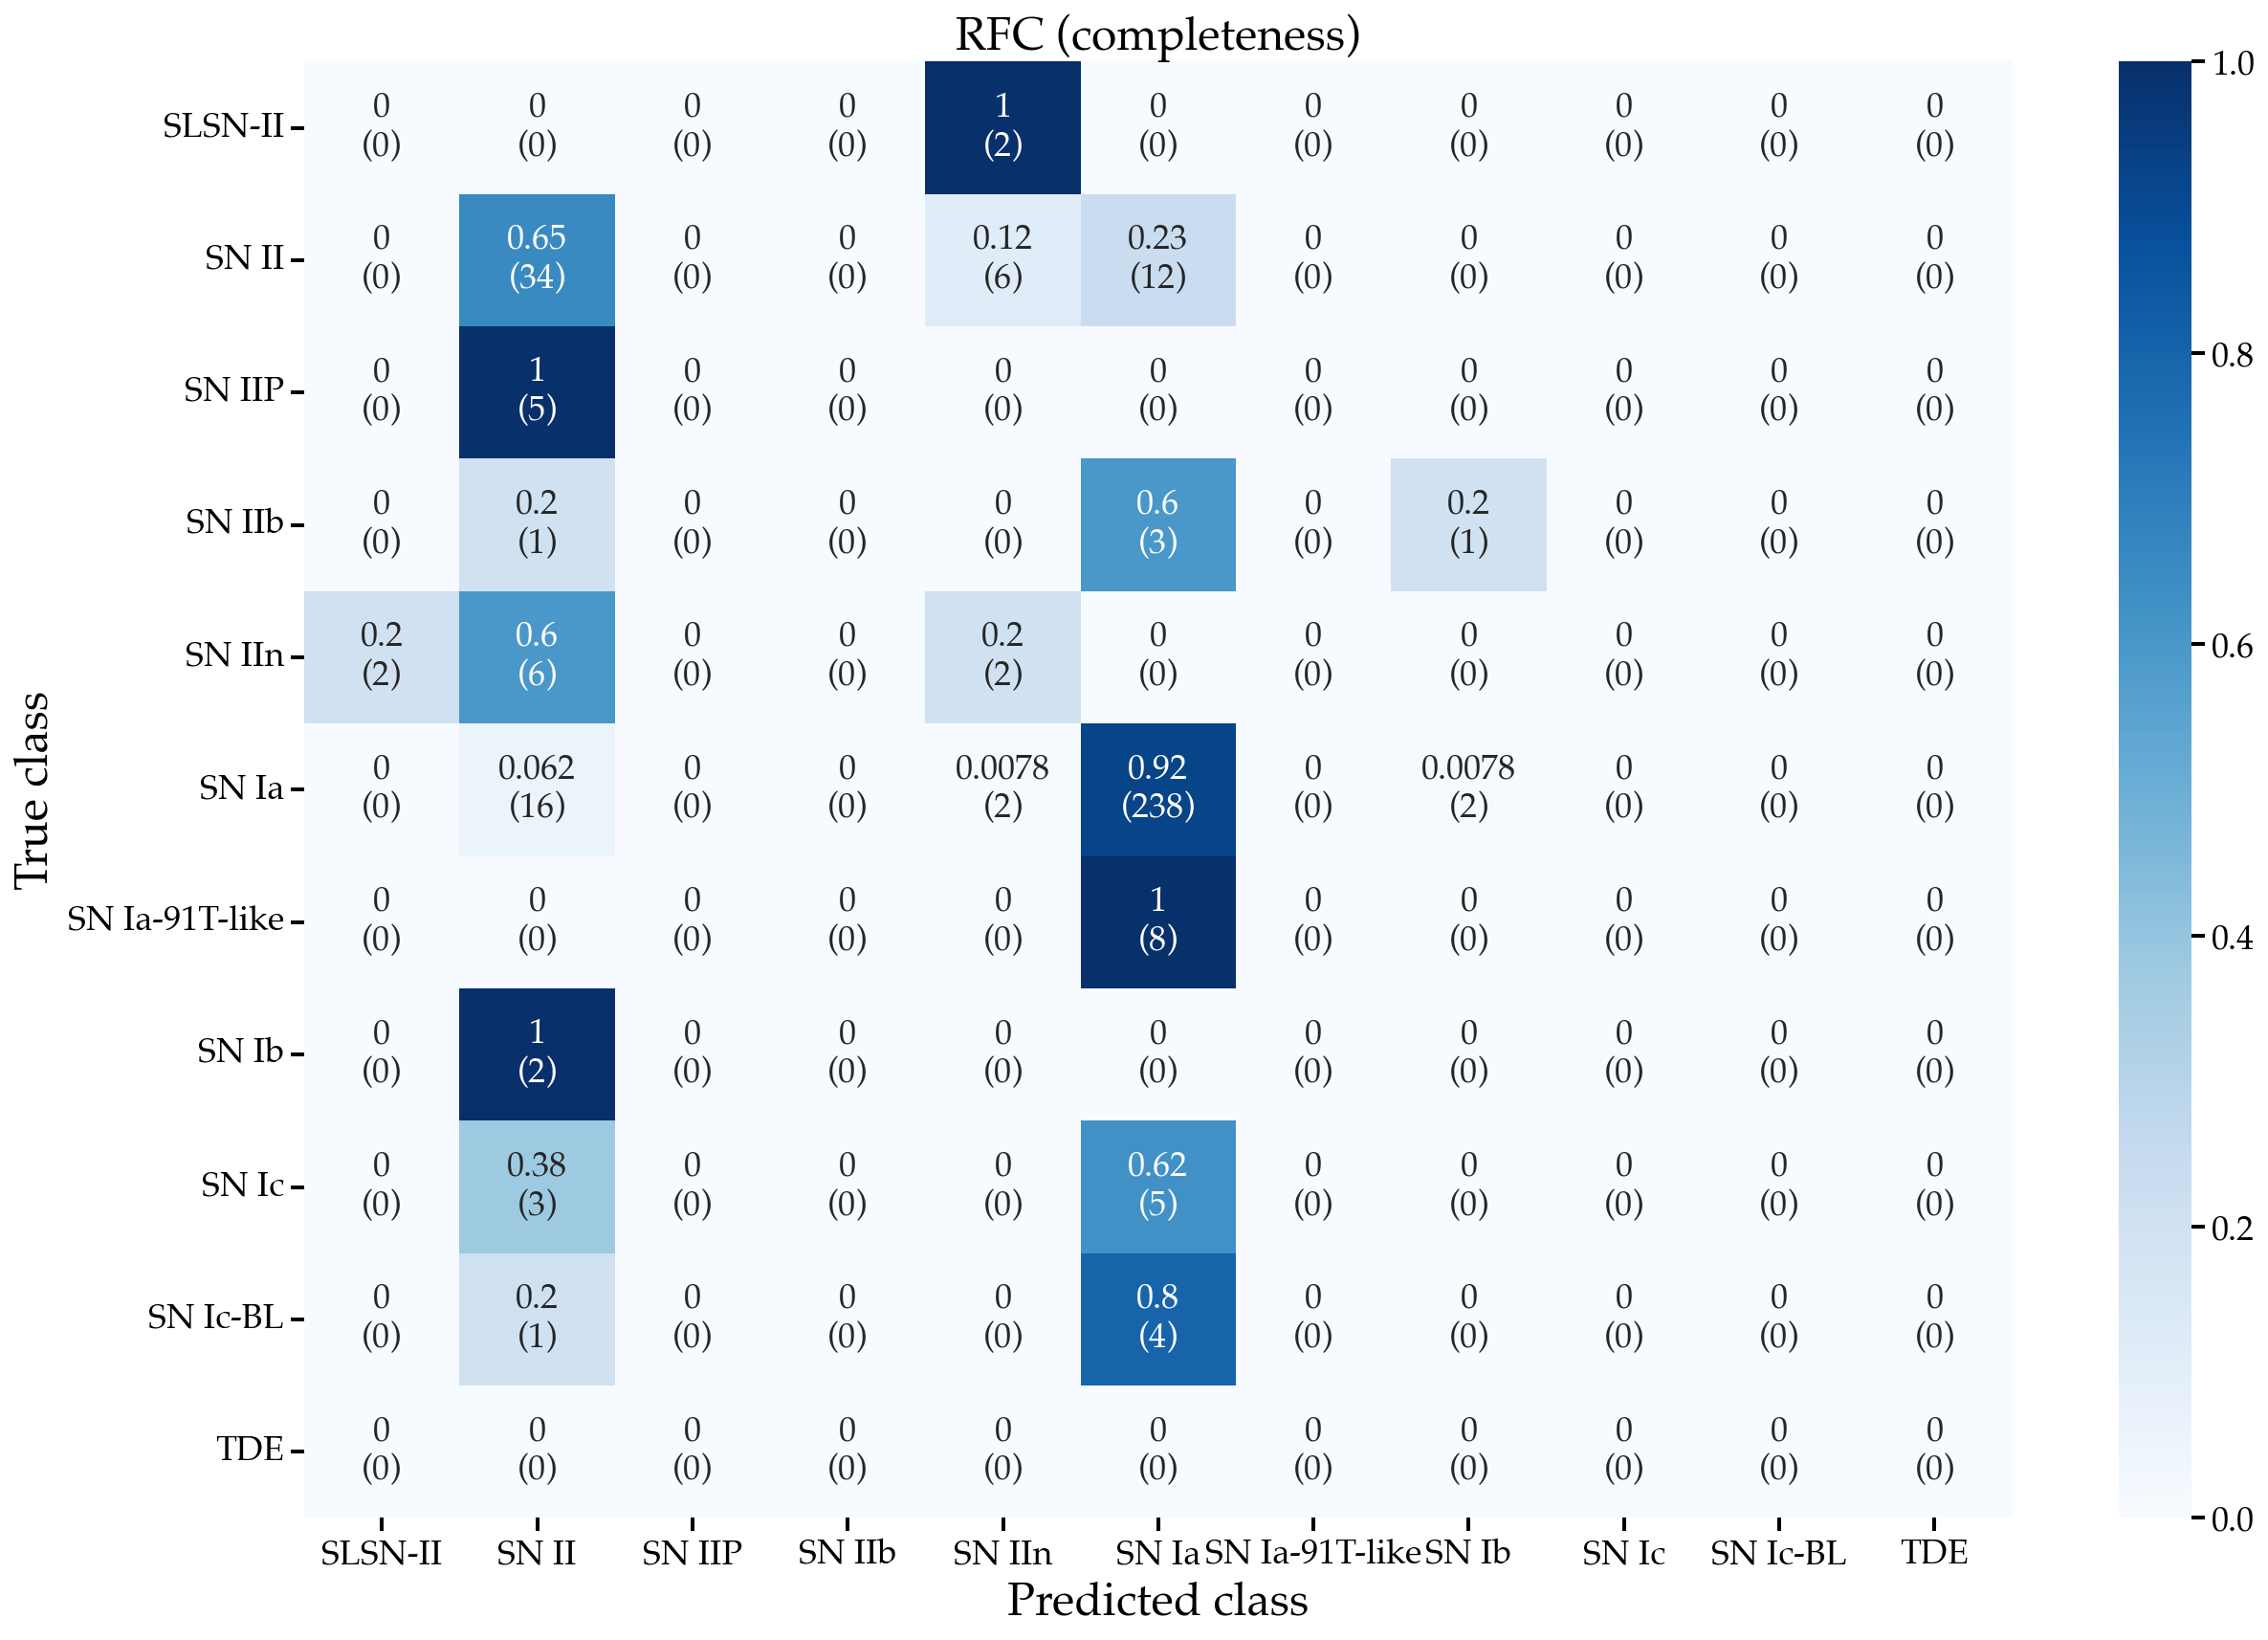

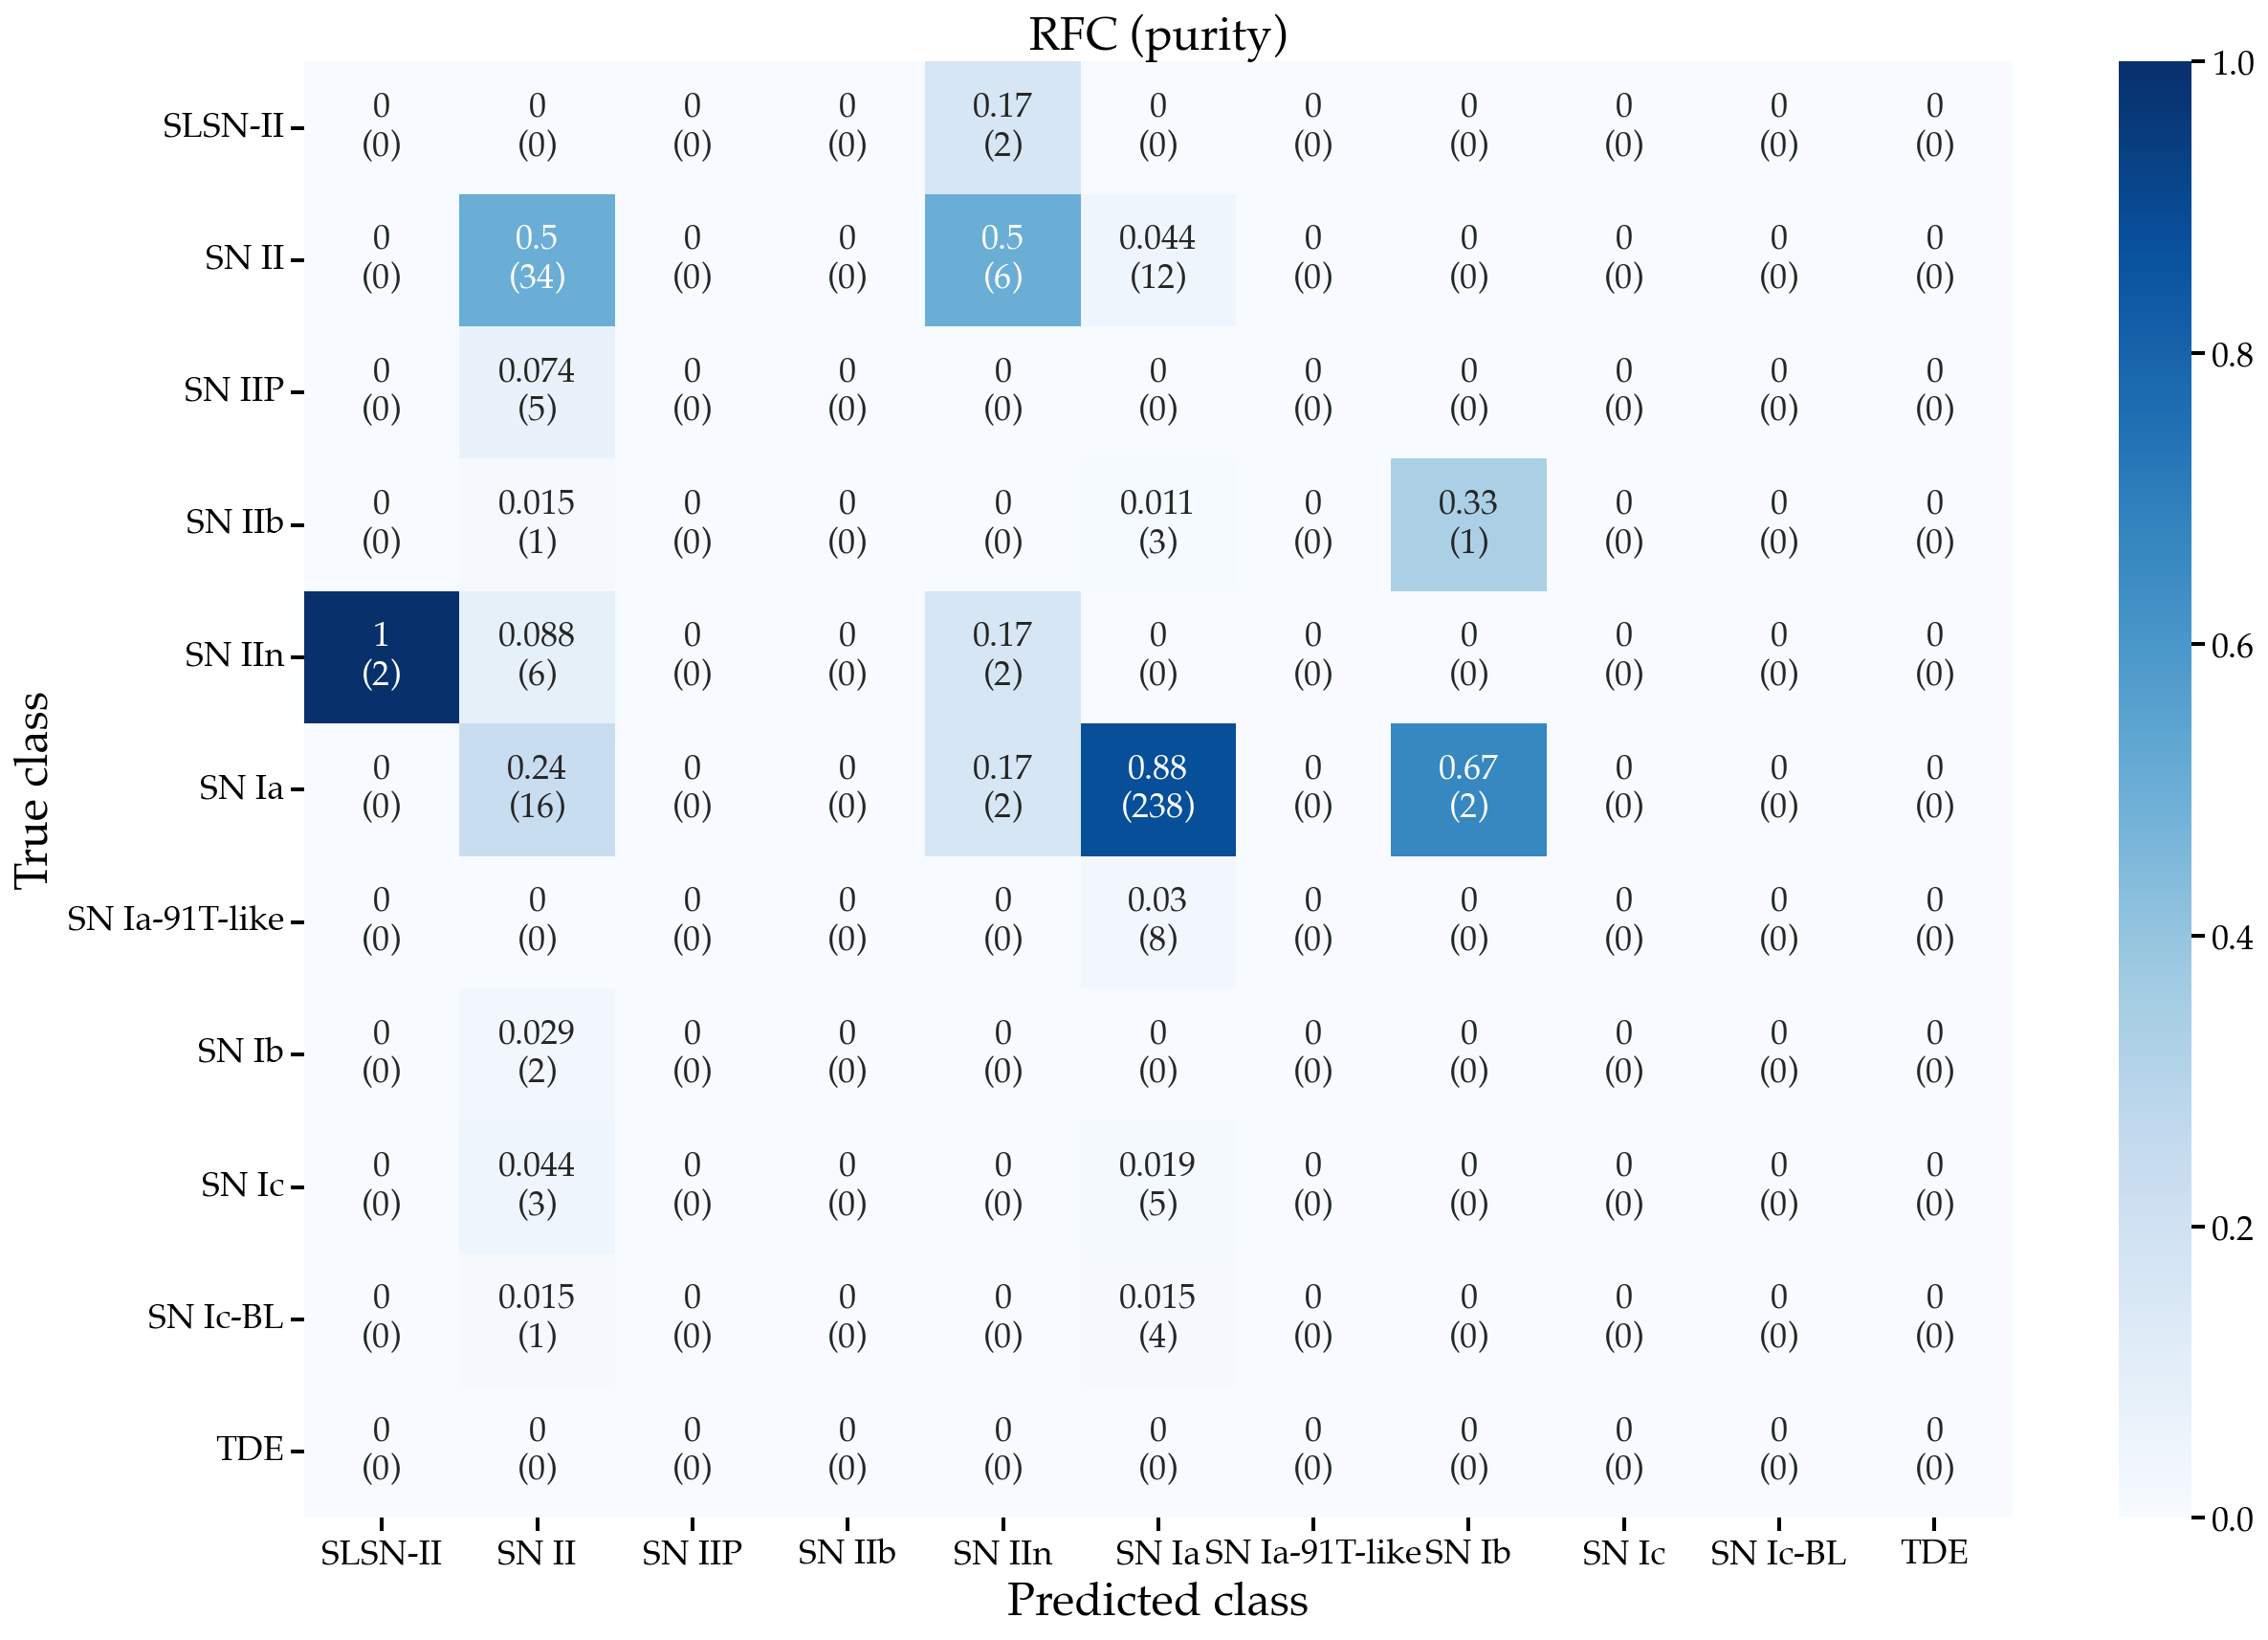

In [47]:
# Confusion matrices
title='RFC'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [48]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = df2.copy()
ann0_ann1_df_noNone_sim_class['tns_cls'] = ann0_ann1_df_noNone_sim_class['tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['RFC_best_cls'] = ann0_ann1_df_noNone_sim_class['RFC_best_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [49]:
ann0_ann1_df_noNone_sim_class

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.223705,0.773077,0.806313,59.085444,1.676581,1.664820,0.108048,0.176453,7.362063,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,6.200716,7.149195,1.931035,8.050465,0.353874,17.188187,13.138665,0.800000,0.600112,SN II
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.603846,0.400000,1.479537,23.881055,7.737042,0.912698,0.500000,0.300135,7.880763,None
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.300000,2.256852,2.843934,53.110385,5.765987,1.631209,3.322487,3.901745,0.902632,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.000000,0.600000,5.500000,28.294215,12.300826,0.800000,0.000000,0.800000,7.100000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.000000,8.478126,3.473228,58.761144,6.374638,0.701579,2.304181,1.709477,2.350000,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.110774,0.531619,58.039763,10.354040,0.358350,0.011386,1.118670,8.550188,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.000000,3.200000,1.600000,86.000183,0.300183,0.199452,1.100000,0.100000,0.400000,SN Ia


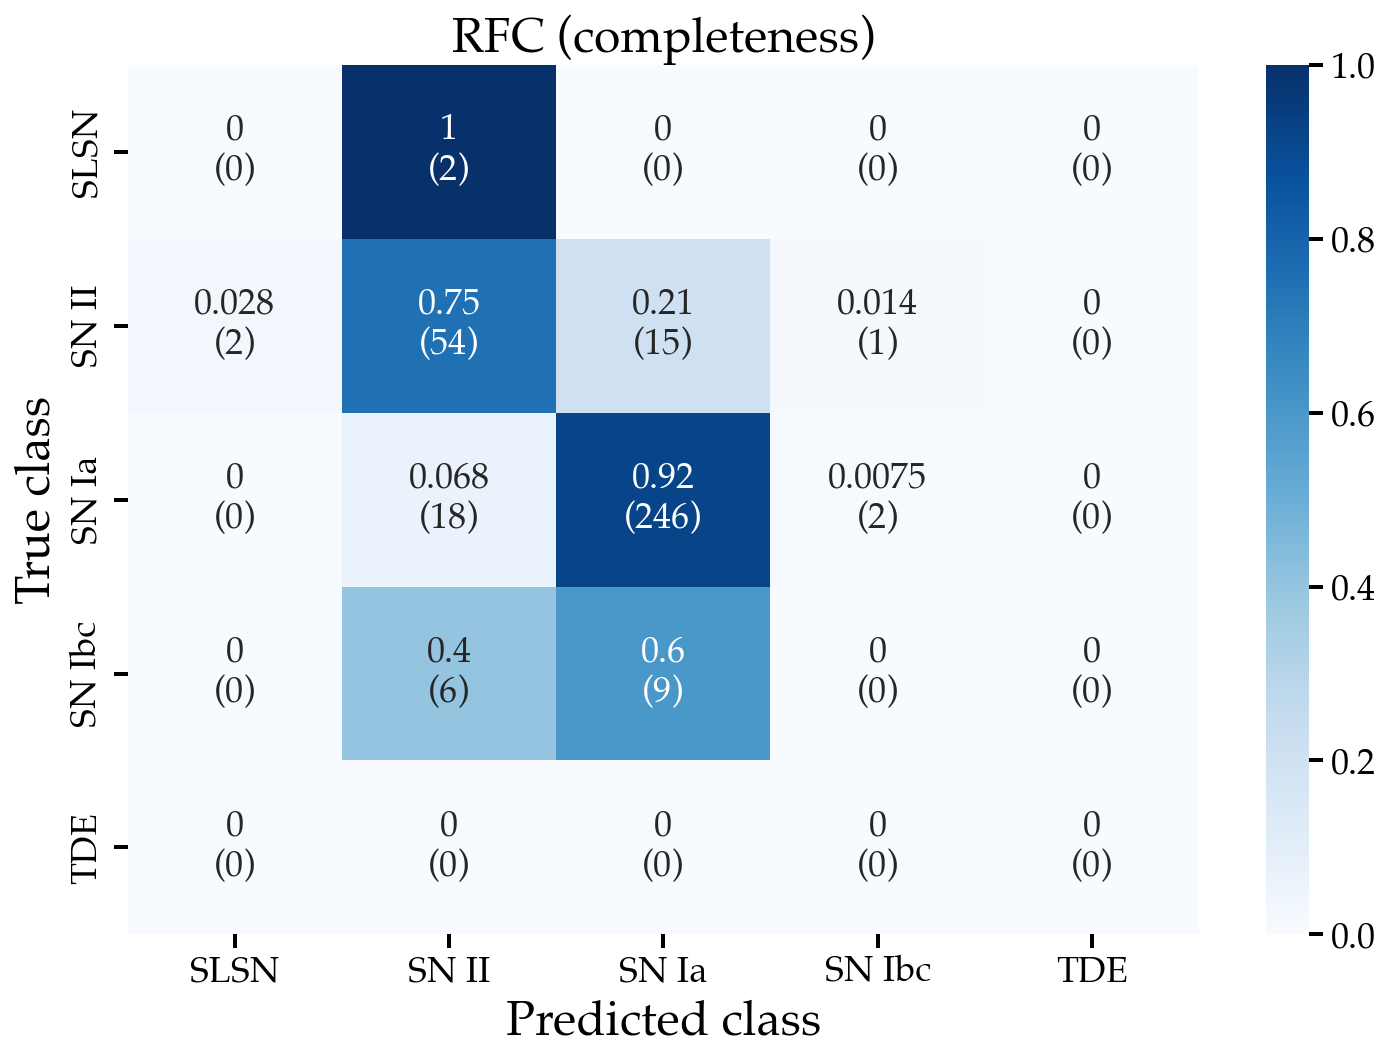

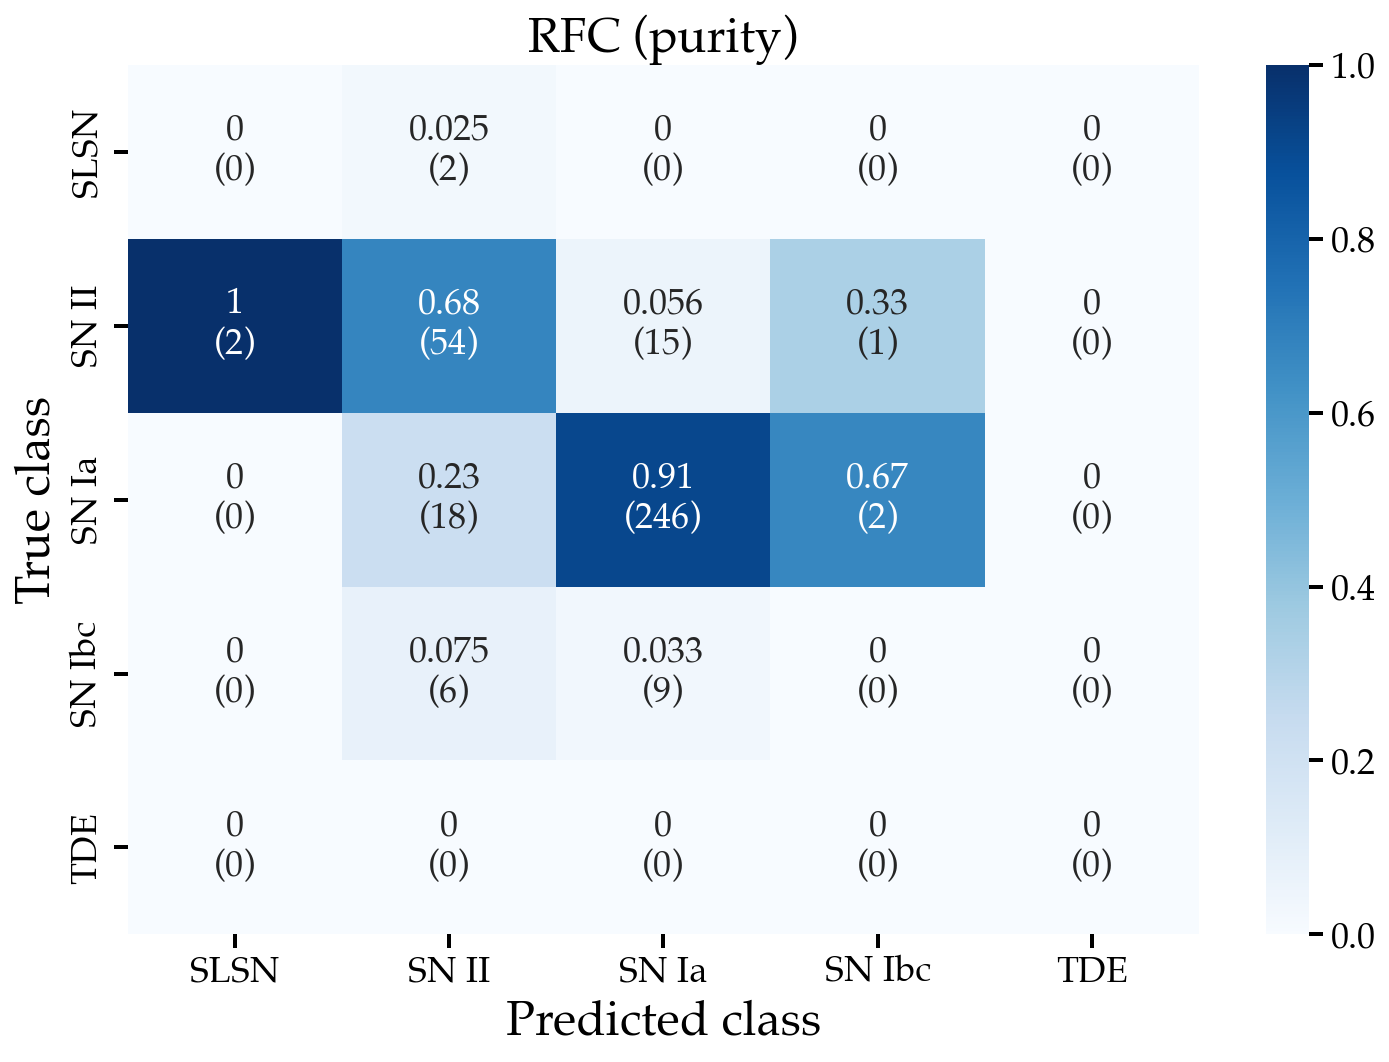

In [50]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [51]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = df2.copy()
ann0_ann1_df_noNone_bin_class['tns_cls'] = ann0_ann1_df_noNone_bin_class['tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['RFC_best_cls'] = ann0_ann1_df_noNone_bin_class['RFC_best_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [52]:
mask = (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.223705,0.773077,0.806313,59.085444,1.676581,1.664820,0.108048,0.176453,7.362063,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,6.200716,7.149195,1.931035,8.050465,0.353874,17.188187,13.138665,0.800000,0.600112,SN CC
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.603846,0.400000,1.479537,23.881055,7.737042,0.912698,0.500000,0.300135,7.880763,None
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.300000,2.256852,2.843934,53.110385,5.765987,1.631209,3.322487,3.901745,0.902632,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.000000,0.600000,5.500000,28.294215,12.300826,0.800000,0.000000,0.800000,7.100000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.000000,8.478126,3.473228,58.761144,6.374638,0.701579,2.304181,1.709477,2.350000,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.110774,0.531619,58.039763,10.354040,0.358350,0.011386,1.118670,8.550188,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.000000,3.200000,1.600000,86.000183,0.300183,0.199452,1.100000,0.100000,0.400000,SN Ia


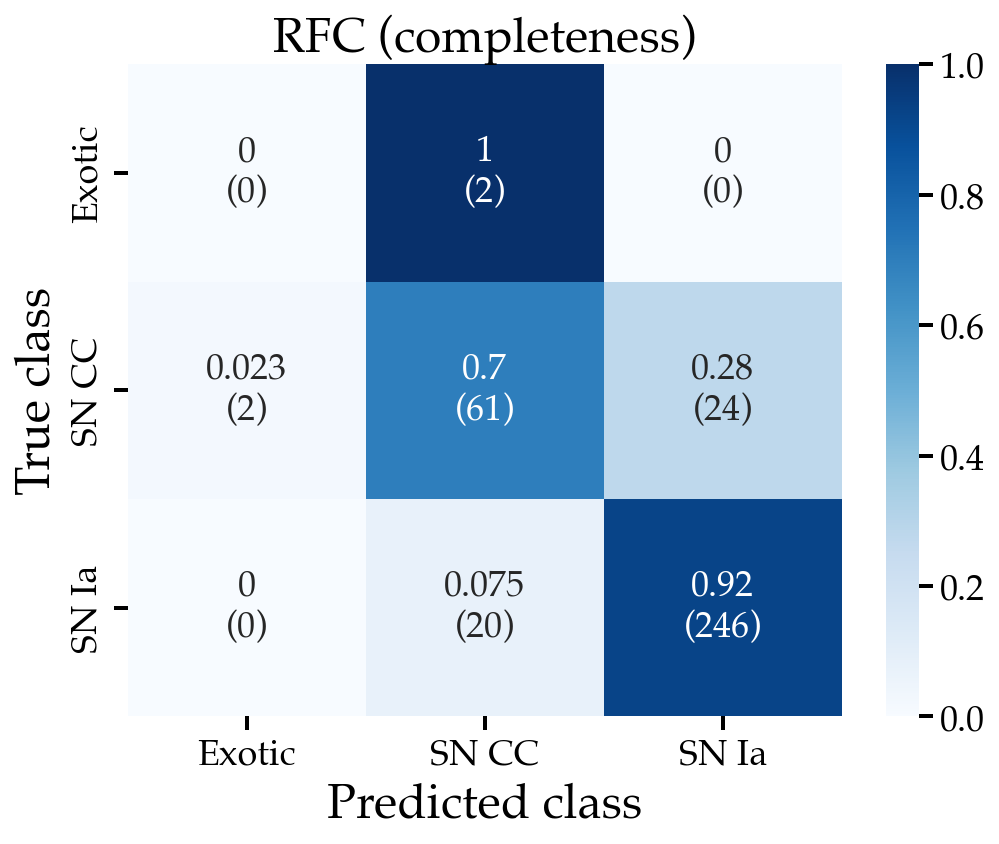

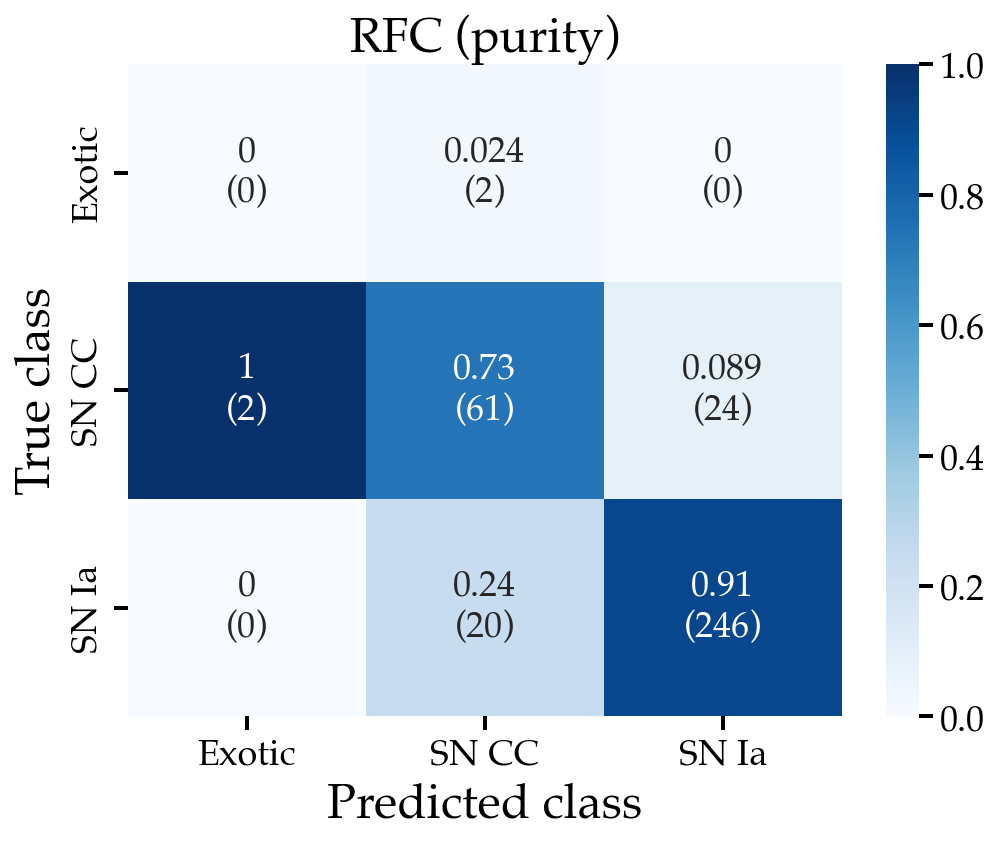

In [53]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [54]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = df2.copy()
ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'] = ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [55]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.223705,0.773077,0.806313,59.085444,1.676581,1.664820,0.108048,0.176453,7.362063,NOT Rare
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,6.200716,7.149195,1.931035,8.050465,0.353874,17.188187,13.138665,0.800000,0.600112,Rare
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.603846,0.400000,1.479537,23.881055,7.737042,0.912698,0.500000,0.300135,7.880763,NOT Rare
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.300000,2.256852,2.843934,53.110385,5.765987,1.631209,3.322487,3.901745,0.902632,NOT Rare
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.000000,0.600000,5.500000,28.294215,12.300826,0.800000,0.000000,0.800000,7.100000,NOT Rare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.000000,8.478126,3.473228,58.761144,6.374638,0.701579,2.304181,1.709477,2.350000,NOT Rare
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.110774,0.531619,58.039763,10.354040,0.358350,0.011386,1.118670,8.550188,NOT Rare
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.000000,3.200000,1.600000,86.000183,0.300183,0.199452,1.100000,0.100000,0.400000,NOT Rare


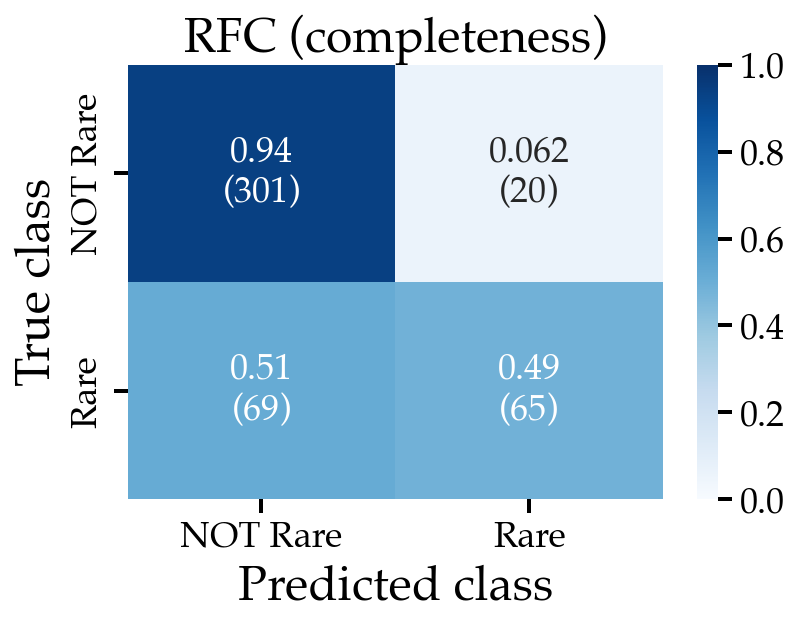

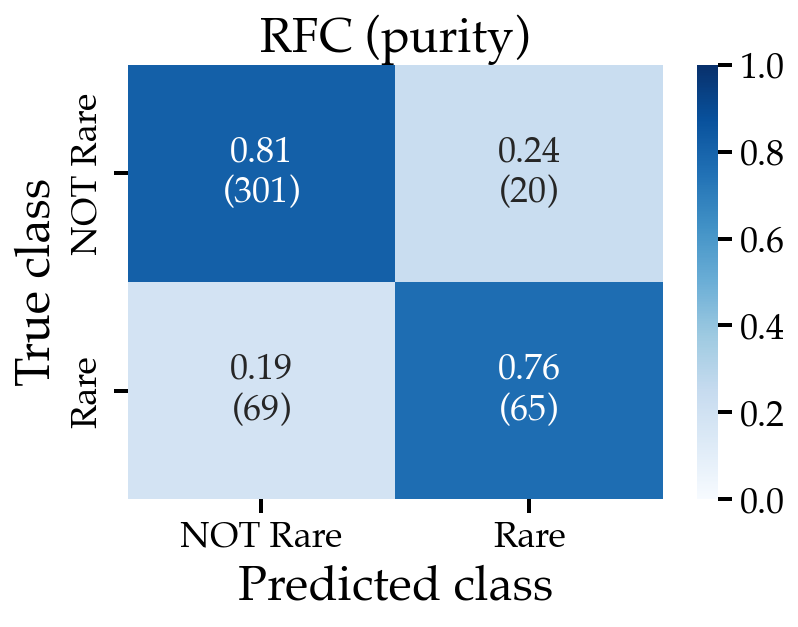

In [56]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()